In [1]:
import cv2
import numpy as np
import pandas as pd
import json
from data import findSegments,findBumps,findBoundaries
def coco_data(filelist): #pass a list of filename paths; for each path, take filename as image_id (volID_XXX.png where XXX is scan number) 
    dataset = dict(info = {}, images = [], categories = [{'id':int(0), 'name':'rpd'}],licenses=None, annotations=[] )
    instances = 0
    wrong_poly = 0
    ifiles=0

    for fn in filelist:
        imageid = fn.split("/")[-1]
        if '_' not in imageid:
            imageid = imageid.replace('.tiff','_0.tiff')
        seg = cv2.imread(fn)
        dat = dict(file_name = fn, height = seg.shape[0], width = seg.shape[1], id = imageid)
        dataset['images'].append(dat)
          
        if (np.max(seg) != 0):
            
            seg = seg[:, :, 0]
            ret,binseg = cv2.threshold(seg, 128, 255, cv2.THRESH_BINARY) #sourch seg is grayscale
            
            #integral of segmentation
            y = (binseg/binseg.max()).sum(axis=0).astype(int) 
            df = pd.DataFrame(y,columns=['y'])
            #find and break up segments into instances
            segs = findSegments(df)
            bumps = findBumps(df,segs,thresh=3)
            idx = findBoundaries(df,bumps)
            #insert breaks in image
            for i in idx:
                binseg[:,i]=0
            # if len(idx)>0:
            #     fig,ax = visualize_breakup(im[:,:,0],binseg,segs,bumps,idx)
            #     pdf.savefig(fig)
            #     plt.close(fig)
            
            #find contours and bounding boxes
            #pdb.set_trace()
            contours, hierarchy = cv2.findContours(binseg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for c in contours:
                instances += 1
                x,y,w,h = cv2.boundingRect(c)
                area = cv2.contourArea(c)
                if len(c) < 4: 
                    wrong_poly += 1
                    continue

                anot = dict(
                        image_id = imageid,
                        id = instances+1,
                        bbox = (x,y,w,h),  
                        category_id = 0,
                        area = area,
                        iscrowd=0,
                        segmentation = [c.flatten().tolist()],
                        score = 1.0)
                dataset["annotations"].append(anot)
        
        ifiles=ifiles+1
#             if ii==500:
#                 break
    print(f"Found {len(dataset['images'])} images")
    print(f"Found {instances} instances")
    print(f"Found {wrong_poly} too few vertices")
    return dataset

In [2]:
rootdir = '/data/amd-data/cera-rpddata/Interrater_agreement_outputs'
import glob, os
#subdirs = ['Grader 1','Grader 2','Grader 3','Model']
subdirs = ['Grader 4']
for subdir in subdirs:
    
    files = glob.glob(os.path.join(rootdir,subdir,'*.tiff'),recursive=True)
    # files = [f.replace('.tiff','_0.tiff') for f in files]
    dat = coco_data(files)
    json.dump(dat,open('interrater_annotation_files/'+subdir.strip(' ')+'.json','w'))


Found 280 images
Found 908 instances
Found 22 too few vertices


In [1]:
from evaluate_graders import EvaluateClassGraders
import pandas as pd
import numpy as np
import sys
sys.path
if '..' not in sys.path:
    sys.path.append('..')
print(sys.path)
import analysis_lib
import matplotlib.pyplot as plt
plt.style.use('ybpres.mplstyle')
import seaborn as sns

labels = ['G1','G2','G3','G4','M']
filelist = ['interrater_annotation_files/Grader 1.json',
'interrater_annotation_files/Grader 2.json',
'interrater_annotation_files/Grader 3.json',
'interrater_annotation_files/Grader 4.json',
'interrater_annotation_files/Model.json']
F1_instances = pd.DataFrame(index=labels,columns=labels)
F1_instances_lo = pd.DataFrame(index=labels,columns=labels)
F1_instances_hi = pd.DataFrame(index=labels,columns=labels)

F1_scans = pd.DataFrame(index=labels,columns=labels)
F1_scans_err = pd.DataFrame(index=labels,columns=labels)

harm_scans = pd.DataFrame(index=labels,columns=labels)
harm_scans_err = pd.DataFrame(index=labels,columns=labels)

num_instances = {}
num_pos_scans = {}
def makeF1matrix(filelist,labels):


    for i,index in enumerate(labels):
        for j,column in zip(range(i+1,len(labels)),labels[(i+1):]):
            myeval = EvaluateClassGraders(annotation_file_gt=filelist[i],annotation_file_dt=filelist[j],iou_thresh=0.2,prob_thresh=.5)
            myeval.evaluate();
            F1_instances.loc[index,column] = myeval.summarize_scalars()['f1']
            F1_instances_lo.loc[index,column] = myeval.summarize_scalars()['f1_ci'][0]
            F1_instances_hi.loc[index,column] = myeval.summarize_scalars()['f1_ci'][1]
            
            F1_instances.loc[column,index] = F1_instances.loc[index,column]
            F1_instances_lo.loc[column,index] = F1_instances_lo.loc[index,column]
            F1_instances_hi.loc[column,index] = F1_instances_hi.loc[index,column]

            def calc_harm_mean_err(f1,pr,rc,int_r,int_p):
                int_f1 =(f1)*np.sqrt(int_r**2 * (1/rc - 1/(pr+rc))**2 + int_p**2 * (1/pr - 1/(pr+rc))**2)
                return int_f1
            def calc_harm(pr,rc):
                return 2*pr*rc/(pr+rc)

            ##scan level
            tables = analysis_lib.CreatePlotsRPD.initfromcoco(myeval.mycoco,prob_thresh = myeval.prob_thresh)
            gt = tables.dfimg.gt_instances>0
            dt = tables.dfimg.dt_instances>0

            num_instances[index] = tables.dfimg.gt_instances.sum()
            num_instances[column] = tables.dfimg.dt_instances.sum()
            num_pos_scans[index]= gt.sum()
            num_pos_scans[column]= dt.sum()

            rc = (gt&dt).sum()/gt.sum()
            pr = (gt&dt).sum()/dt.sum()
            f1 = calc_harm(pr,rc)

            fpr = ((~gt)&(dt)).sum()/((~gt).sum())
            fom = ((~dt)&(gt)).sum()/((~dt).sum())
            #fpr_harm = calc_harm(fpr,fom)

            spc = ((~gt)&(~dt)).sum()/((~gt).sum())
            npv = ((~dt)&(~gt)).sum()/((~dt).sum())
            harm = calc_harm(spc,npv)


            #propogate errors for f1
            int_r = analysis_lib.stat_CI(rc,gt.sum(),1.96)
            int_p = analysis_lib.stat_CI(pr,dt.sum(),1.96)
            int_f1 = calc_harm_mean_err(f1,pr,rc,int_r,int_p)
            
            #propogate errors for harm
            int_spc = analysis_lib.stat_CI(spc,(~gt).sum(),1.96)
            int_npv = analysis_lib.stat_CI(npv,(~dt).sum(),1.96)
            int_harm = calc_harm_mean_err(harm,spc,npv,int_spc,int_npv)

            #propogate errors for fpr harm
            int_fpr = analysis_lib.Wilson_CI(fpr,(~gt).sum(),1.96)
            int_fom = analysis_lib.Wilson_CI(fom,(~dt).sum(),1.96)
            #int_fpr_harm = calc_harm_mean_err(fpr_harm,fpr,fom,int_fpr,int_fom)

            F1_scans.loc[column,index] = f1
            F1_scans_err.loc[column,index] = int_f1

            F1_scans.loc[index,column] = f1
            F1_scans_err.loc[index,column] = int_f1

            # harm_scans.loc[column,index] = harm
            # harm_scans_err.loc[column,index] = int_harm
            # harm_scans.loc[index,column] = harm
            # harm_scans_err.loc[index,column] = int_harm
            
            
            harm_scans.loc[index,column] = fpr
            harm_scans_err.loc[index,column] = int_fpr
            harm_scans.loc[column,index] = fom
            harm_scans_err.loc[column,index] = int_fom

            print(i,j,index,column)


            
    

makeF1matrix(filelist,labels)



['/data/amd-data/cera-rpd/detectron2-rpd/datasets', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/root/.local/lib/python3.7/site-packages', '..']
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Calculated metrics for 280 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.00s).
0 1 G1 G2
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Calculated metrics for 280 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
0 

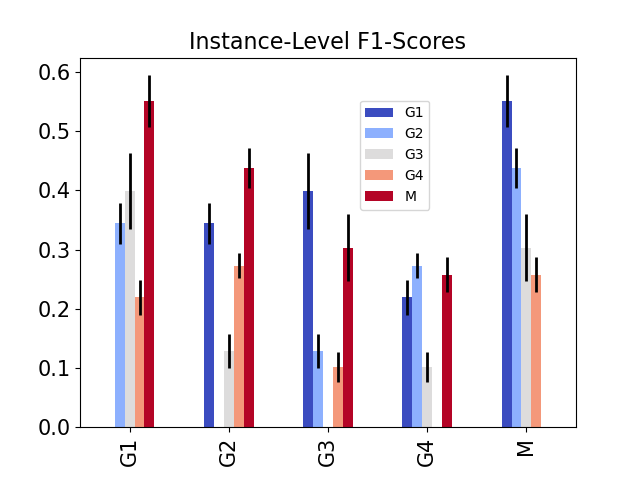

In [3]:
%matplotlib widget

errors = F1_instances - F1_instances_lo #symmetric anyway


ax = F1_instances.plot(kind='bar',yerr= errors,title='Instance-Level F1-Scores',cmap='coolwarm')
plt.legend(bbox_to_anchor=[.55,.57])
plt.gcf().savefig('../ARVO 2022/interrater-instance-level-F1.svg')
#F1_scans.plot(kind='bar',yerr=F1_scans_err, title='Scan-Level F1 Scores')

# harm_scans.plot(kind='bar',yerr = harm_scans_err, title = 'Scan-Level Harmonic(SPC,NPV)')


In [7]:
pd.set_option('display.precision',2)
harm_scans = harm_scans.astype(float)
s = harm_scans.fillna('').style.set_table_styles([{
                                "selector":"th.row_heading",
                                "props": [("font-weight","bold")]},
                                {
                                "selector":"td",
                                "props": [("font-size","100px")]
                                },
                                {
                                "selector":"th",
                                "props": [("font-size","100px")]
                                },])
s = s.background_gradient("coolwarm",axis=None,gmap=harm_scans)

s



,G1,G2,G3,G4,M
G1,,0.36,0.00,0.13,0.08
G2,0.01,,0.00,0.05,0.00
G3,0.15,0.44,,0.20,0.17
G4,0.08,0.35,0.02,,0.06
M,0.06,0.34,0.01,0.09,


In [3]:
harm_scans.fillna('')

,G1,G2,G3,G4,M
G1,,0.359223,0.004854,0.126214,0.07767
G2,0.014925,,0.0,0.052239,0.0
G3,0.145833,0.441667,,0.2,0.166667
G4,0.081633,0.352041,0.020408,,0.061224
M,0.059406,0.336634,0.009901,0.089109,


In [25]:
fpr_pair_max = np.maximum(harm_scans.T,harm_scans).astype(float)


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:360: RuntimeWarning: invalid value encountered in maximum
  result = getattr(ufunc, method)(*inputs, **kwargs)


G1    float64
G2    float64
G3    float64
G4    float64
M     float64
dtype: object

In [26]:
p = fpr_pair_max.style.set_table_styles(s.table_styles)
p = p.background_gradient("coolwarm",axis=None)
p

,G1,G2,G3,G4,M
G1,nan,0.36,0.15,0.13,0.08
G2,0.36,nan,0.44,0.35,0.34
G3,0.15,0.44,nan,0.20,0.17
G4,0.13,0.35,0.20,nan,0.09
M,0.08,0.34,0.17,0.09,nan


In [7]:
pd.DataFrame([num_instances,num_pos_scans], index=['Instances','Pos. Scans'])


,G1,G2,G3,G4,M
Instances,222.0,895.0,80.0,886.0,296.0
Pos. Scans,74.0,146.0,40.0,84.0,78.0


### Volume Level

In [15]:
import sys
sys.path
if '..' not in sys.path:
    sys.path.append('..')
print(sys.path)
import analysis_lib

tables = analysis_lib.CreatePlotsRPD.initfromcoco(myeval.mycoco,prob_thresh = myeval.prob_thresh)
gt = tables.dfimg.gt_instances>0
dt = tables.dfimg.dt_instances>0

rc = (gt&dt).sum()/gt.sum()
pr = (gt&dt).sum()/dt.sum()
f1 = 2*pr*rc/(pr+rc)



['/data/amd-data/cera-rpd/detectron2-rpd/datasets', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/root/.local/lib/python3.7/site-packages', '..']


0.95

In [15]:
from PIL import Image
def image_gen(json_file):
    dataset = json.load(open(json_file,'r'))
    for f in dataset['images']:
        yield Image.open(f['file_name'])

gen = image_gen('interrater_annotation_files/Grader 2.json')


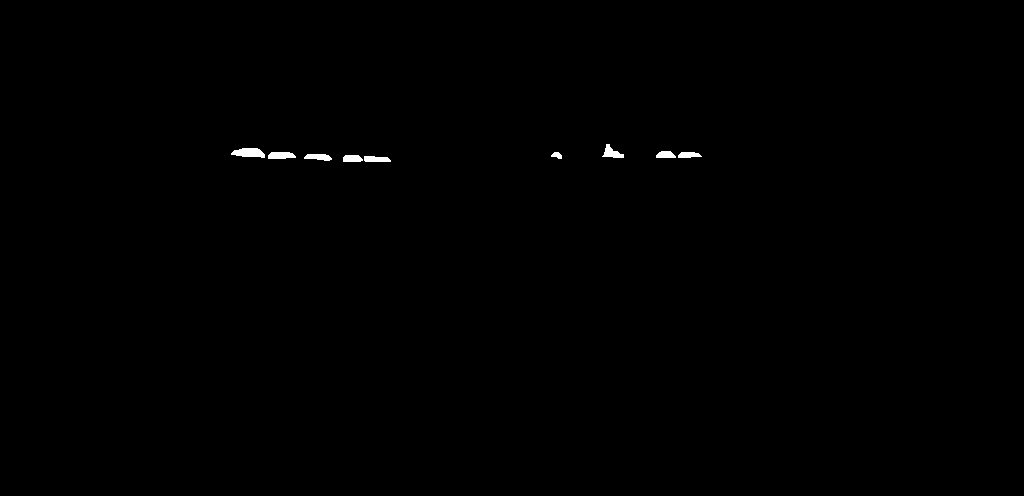

In [87]:
next(gen)

In [14]:
dat['images']

[{'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/236.tiff',
  'height': 496,
  'width': 1024,
  'id': '236_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/17.tiff',
  'height': 496,
  'width': 1024,
  'id': '17_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/173.tiff',
  'height': 496,
  'width': 1024,
  'id': '173_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/138.tiff',
  'height': 496,
  'width': 1024,
  'id': '138_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/84.tiff',
  'height': 496,
  'width': 1024,
  'id': '84_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/109.tiff',
  'height': 496,
  'width': 1024,
  'id': '109_0.tiff'},
 {'file_name': '/data/amd-data/cera-rpddata/Interrater_agreement_outputs/Model/142.tiff',
  'height': 496,
  'width': 1024